In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install seaborn

# Imports

In [101]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline.backend_inline
import seaborn as sns
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Getting data

In [142]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train_set.drop('id',axis='columns', inplace=True)

ids = test_set['id'].to_numpy()


Y = train_set.pop('FloodProbability').to_numpy().reshape(-1,1)
X = train_set.to_numpy()

X_names = train_set.columns

print(X.shape, Y.shape)

(1117957, 20) (1117957, 1)


# Spliting data


In [155]:
x_train, x_cv, y_train, y_cv = train_test_split(X,Y,test_size=0.2)
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_cv = torch.Tensor(x_cv)
y_cv = torch.Tensor(y_cv)

print(x_train.shape,y_train.shape)


torch.Size([894365, 20]) torch.Size([894365, 1])


In [154]:
scaler = StandardScaler().fit(x_train)
x_train = torch.Tensor(scaler.transform(x_train))
x_cv = torch.Tensor(scaler.transform(x_cv))
print(x_train[:5,:])

tensor([[-2.3940,  0.0353, -0.4613,  0.5151,  2.9089, -0.4538,  0.9828, -1.4175,
          0.5121,  0.0243,  1.9522, -1.4223, -0.9356, -0.9295,  0.9949, -0.4489,
          0.5156,  0.0236,  0.5101, -2.3630],
        [-0.4486, -0.4423, -0.4613,  1.0025, -0.4523, -1.4258,  1.9435, -0.9334,
         -0.4549, -0.4556, -0.4547,  0.0250,  0.0220,  0.0329,  0.0343,  0.0354,
         -1.4111,  0.5071, -0.9327, -1.4060],
        [-0.9350, -0.4423, -0.4613,  0.5151, -0.4523, -0.4538,  0.0221, -0.4494,
         -0.4549, -0.4556,  0.5081,  0.9898,  1.4584,  0.9952,  0.9949, -0.9332,
         -1.4111, -0.9434,  0.0292, -2.3630],
        [ 1.0104,  1.4681,  0.5043,  0.5151, -0.4523, -1.4258, -0.9386,  1.0028,
         -0.4549,  0.5042, -0.4547,  0.5074, -0.9356, -0.4483, -0.4460,  0.0354,
         -1.4111,  0.9905,  0.0292,  0.5078],
        [ 0.5240,  2.4233, -0.4613, -0.4597, -0.4523, -0.9398,  1.4631,  0.0347,
          0.0286, -0.4556,  0.0267, -0.9399,  0.5008, -1.4107,  0.5146,  1.0040,
      

In [64]:
class floodProb(nn.Module):
    def __init__(self,nUnits,nLayers):
        '''Populate with the layers of the model'''
        super(floodProb,self).__init__()

        self.nLayers = nLayers
        
        self.layers = nn.ModuleDict({name:layer for name,layer in zip([f'hidden{i}' for i in range(nLayers)],[nn.Linear(nUnits,nUnits) for j in range(nLayers)])})
        
        self.layers['input'] = nn.Linear(in_features=20,out_features=nUnits)
        self.layers['output'] = nn.Linear(nUnits,1)


    def forward(self,x):
        '''Operations that are taking place in the layers'''

        # input
        x = F.relu(self.layers['input'](x))
        for l in range(self.nLayers):
            x = F.relu(self.layers[f'hidden{l}'](x))
        # output
        x = F.sigmoid(self.layers['output'](x))

        return x

In [9]:
def train(model, lossfun, optimizer, inputs, targets, epochs=100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    inputs, targets = inputs.to(device), targets.to(device)
    
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfun(outputs, targets)
        loss.backward()
        optimizer.step()
        losses[epoch] = loss.item()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()}')
    return losses

Epoch 0/100 - Loss: 0.005201925057917833
Epoch 10/100 - Loss: 0.0026371274143457413
Epoch 20/100 - Loss: 0.0026078037917613983
Epoch 30/100 - Loss: 0.0026069830637425184
Epoch 40/100 - Loss: 0.0026060317177325487
Epoch 50/100 - Loss: 0.0026053625624626875
Epoch 60/100 - Loss: 0.002605078974738717
Epoch 70/100 - Loss: 0.002605125540867448
Epoch 80/100 - Loss: 0.0026050780434161425
Epoch 90/100 - Loss: 0.002605058718472719
tensor([[0.5045],
        [0.5045],
        [0.5045],
        ...,
        [0.5045],
        [0.5045],
        [0.5045]], device='cuda:0')
tensor(0.6931, device='cuda:0')


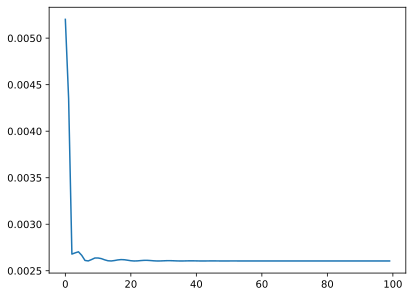

In [71]:
# test
epochs = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

model = floodProb(20,5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.06)
model.train()
losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)

model.eval()
with torch.no_grad():
    outputs = model(x_cv.to(device))
    print(outputs)
    loss_cv = nn.BCELoss()(outputs, y_cv.to(device))

print(loss_cv)
plt.plot(losses)

In [45]:
nLayers = range(1,6)
nUnits = np.arange(1,50,3)
nTests = range(10)
all_cvlosses = np.zeros((len(nUnits),len(nLayers),len(nTests)))
for iter in nTests:
    for idxl,l in enumerate(nLayers):
        for idxu,u in enumerate(nUnits):
            model = floodProb(u,l)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.06)
        
            model.train()
            losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)

            model.eval()
            with torch.no_grad():
                outputs = model(x_cv.to(device))
                loss_cv = nn.MSELoss()(outputs, y_cv.to(device))
                all_cvlosses[idxu,idxl,iter] = loss_cv

        


Epoch 0/100 - Loss: 0.04167584702372551
Epoch 10/100 - Loss: 0.00733798835426569
Epoch 20/100 - Loss: 0.004544519353657961
Epoch 30/100 - Loss: 0.0033573906403034925
Epoch 40/100 - Loss: 0.00285124103538692
Epoch 50/100 - Loss: 0.0026605911552906036
Epoch 60/100 - Loss: 0.0026083672419190407
Epoch 70/100 - Loss: 0.002606891794130206
Epoch 80/100 - Loss: 0.0026097579393535852
Epoch 90/100 - Loss: 0.002606842201203108
Epoch 0/100 - Loss: 0.07609806209802628
Epoch 10/100 - Loss: 0.004426359198987484
Epoch 20/100 - Loss: 0.002292211167514324
Epoch 30/100 - Loss: 0.0014709143433719873
Epoch 40/100 - Loss: 0.00110534206032753
Epoch 50/100 - Loss: 0.0009622406214475632
Epoch 60/100 - Loss: 0.0008412248571403325
Epoch 70/100 - Loss: 0.0007688489276915789
Epoch 80/100 - Loss: 0.0006912259268574417
Epoch 90/100 - Loss: 0.0006082735490053892
Epoch 0/100 - Loss: 0.17500968277454376
Epoch 10/100 - Loss: 0.004562705755233765
Epoch 20/100 - Loss: 0.0018054918618872762
Epoch 30/100 - Loss: 0.001397520

[[0.00072104 0.00045897 0.0006064  0.00050038 0.00064916 0.0004931
  0.00060603 0.00059925 0.0004554  0.00042713]
 [0.00047625 0.00064805 0.00045037 0.00257415 0.00049844 0.00254085
  0.00089558 0.00055643 0.00084826 0.00058506]
 [0.00065392 0.00058633 0.00260126 0.00067232 0.00260042 0.00101272
  0.00039514 0.0026005  0.00260074 0.00046018]
 [0.00260253 0.00260037 0.00260783 0.00053933 0.00260038 0.00260045
  0.00260693 0.00260235 0.00260324 0.00042532]
 [0.00260042 0.00257148 0.00260977 0.00260044 0.00260132 0.00043177
  0.00260143 0.00260225 0.00260054 0.00259983]]


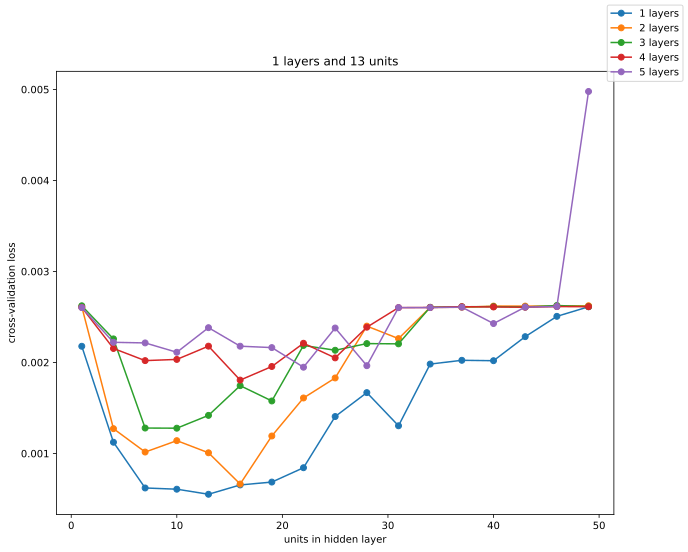

In [72]:
mean_losses = np.mean(all_cvlosses,axis=2)
print(all_cvlosses[4,])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(nUnits,mean_losses,"o-",label=[f"{i+1} layers" for i in range(all_cvlosses.shape[1])])
ax.set_xlabel("units in hidden layer")
ax.set_ylabel("cross-validation loss")
for l in range(mean_losses.shape[1]):
    for u,i in enumerate(mean_losses[:,l]):
        if i == np.min(mean_losses.flatten()):
            best_arq = (l,nUnits[u])
ax.set_title(f"layers and units performance")

fig.legend()

In [124]:
# search best learning rate
epochs = 200
num_lr = 100
lrs = np.linspace(0.01, 0.1, 100)
all_losses = np.zeros((epochs, num_lr))
all_cv = np.zeros((1, num_lr))

torch.manual_seed(1)

for idx, lr in enumerate(lrs):
    model = floodProb(13,1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    
    if idx == 0:
        initial_state = copy.deepcopy(model.state_dict())
    else:
        model.load_state_dict(copy.deepcopy(initial_state))

    model.train()
    losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)
    
    model.eval()
    with torch.no_grad():
        outputs = model(x_cv.to(device))
        loss_cv = nn.MSELoss()(outputs, y_cv.to(device))
        
    all_cv[0, idx] = loss_cv.item()
    all_losses[:, idx] = losses

Epoch 0/200 - Loss: 0.00343702407553792
Epoch 10/200 - Loss: 0.0009920211741700768
Epoch 20/200 - Loss: 0.0005837199278175831
Epoch 30/200 - Loss: 0.00047997027286328375
Epoch 40/200 - Loss: 0.00043493896373547614
Epoch 50/200 - Loss: 0.000420627387939021
Epoch 60/200 - Loss: 0.0004121631500311196
Epoch 70/200 - Loss: 0.00040697460644878447
Epoch 80/200 - Loss: 0.00040359050035476685
Epoch 90/200 - Loss: 0.0004007069510407746
Epoch 100/200 - Loss: 0.00039853775524534285
Epoch 110/200 - Loss: 0.00039664204814471304
Epoch 120/200 - Loss: 0.0003950339159928262
Epoch 130/200 - Loss: 0.0003936388238798827
Epoch 140/200 - Loss: 0.0003924107295460999
Epoch 150/200 - Loss: 0.00039131040102802217
Epoch 160/200 - Loss: 0.00039029010804370046
Epoch 170/200 - Loss: 0.000389310356695205
Epoch 180/200 - Loss: 0.00038833770668134093
Epoch 190/200 - Loss: 0.00038735888665542006
Epoch 0/200 - Loss: 0.00343702407553792
Epoch 10/200 - Loss: 0.0009525202331133187
Epoch 20/200 - Loss: 0.0005734508158639073

KeyboardInterrupt: 

(200, 100)


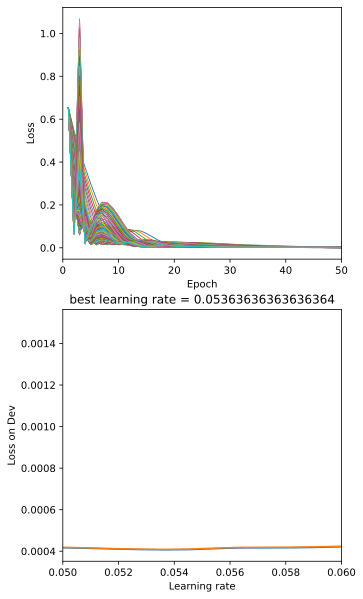

In [60]:
# show the losses
fig,ax = plt.subplots(2,figsize=(5,10), gridspec_kw={'height_ratios': [1, 1]})
for idx,lr in enumerate(lrs):
    ax[0].plot(range(1,201),all_losses[:,idx],'-',markerfacecolor='w',linewidth=.9,label=f"{np.round(lr,3)}")
    ax[0].set_xlim((0,50))
    ax[0].set_xlabel('Epoch'), ax[0].set_ylabel('Loss')
ax[1].plot(lrs,all_cv.flatten())
print(all_losses.shape)
ax[1].plot(lrs[:],all_losses[-1,:])
ax[1].set_xlim((0.05,0.06))
ax[1].set_xlabel('Learning rate'), ax[1].set_ylabel('Loss on Dev')
for i,j in zip(all_cv.flatten(),lrs):
    if i == np.min(all_cv.flatten()):
        bestlr = j
ax[1].set_title(f"best learning rate = {bestlr}");


In [ ]:

lr = bestlr
lossfuns = nn.MSELoss()

Epoch 0/1000 - Loss: 0.0032019945792853832
Epoch 10/1000 - Loss: 0.00127252412494272
Epoch 20/1000 - Loss: 0.0007380185998044908
Epoch 30/1000 - Loss: 0.0005920948460698128
Epoch 40/1000 - Loss: 0.0004885972011834383
Epoch 50/1000 - Loss: 0.00045167570351623
Epoch 60/1000 - Loss: 0.0004240024136379361
Epoch 70/1000 - Loss: 0.0004129504377488047
Epoch 80/1000 - Loss: 0.00040567503310739994
Epoch 90/1000 - Loss: 0.00040069103124551475
Epoch 100/1000 - Loss: 0.0003978038439527154
Epoch 110/1000 - Loss: 0.0003956680011469871
Epoch 120/1000 - Loss: 0.0004889513365924358
Epoch 130/1000 - Loss: 0.00040277509833686054
Epoch 140/1000 - Loss: 0.0003928107034880668
Epoch 150/1000 - Loss: 0.00038793589919805527
Epoch 160/1000 - Loss: 0.0003872040833812207
Epoch 170/1000 - Loss: 0.00038603012217208743
Epoch 180/1000 - Loss: 0.00038500732625834644
Epoch 190/1000 - Loss: 0.00038413339643739164
Epoch 200/1000 - Loss: 0.00039005366852506995
Epoch 210/1000 - Loss: 0.000444812118075788
Epoch 220/1000 - L

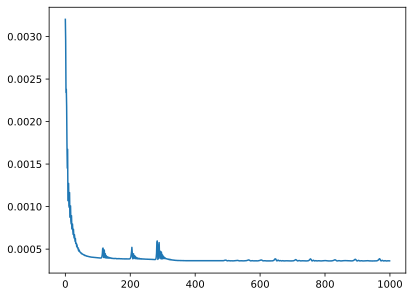

In [137]:
epochs = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

model = floodProb(15,3)

optimizer = torch.optim.Adam(model.parameters(), lr=bestlr)
model.train()
losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)

model.eval()
with torch.no_grad():
    outputs = model(x_cv.to(device))
    print(outputs)
    loss_cv = nn.BCELoss()(outputs, y_cv.to(device))

print(loss_cv)
plt.plot(losses)

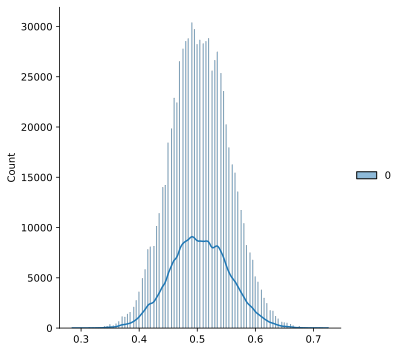

In [105]:

sns.displot(y_train,kde=True)

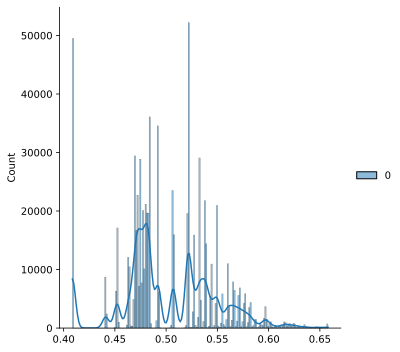

In [120]:
x_test = torch.Tensor(scaler.transform(test_set.to_numpy()[:,1:])).to(device)
y_pred_test = model(x_test).cpu().detach().numpy()

sns.displot(y_pred_test, kde=True)

In [118]:

with open('./data/submission1.csv','w') as sub:
    sub.write("id,FloodProbability\n")
    for id,pred in zip(ids,y_pred_test):
        sub.write(f"{id},{pred[0]}\n")
